In [1]:
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib
print("Matplotlib version for info:", matplotlib.__version__)

Matplotlib version for info: 3.9.4


In [2]:
concept_dict = torch.load('/netscratch/kadir/xl-vlms/results/decompose_activations_text_grounding_image_grounding_results_dog.pth')
#print(results_dict['grounding_words_overlap_matrix'])

concepts = concept_dict['concepts']
activations = concept_dict['activations']
text_grounding = concept_dict['text_grounding']
image_paths = concept_dict['image_grounding_paths']
print (f"Concepts shape: {concepts.shape}", f"Activations shape: {activations.shape}")


Concepts shape: torch.Size([20, 3584]) Activations shape: torch.Size([144, 20])


In [3]:
feat_path = '/netscratch/kadir/xl-vlms/features/save_hidden_states_for_token_of_interest_qwen2_dog_generation_split_test.pth'
test_features = torch.load(feat_path, map_location="cpu")
test_features.keys()

dict_keys(['image', 'model_predictions', 'token_of_interest_mask', 'hidden_states'])

In [4]:
test_images = test_features["image"]
test_prediction = test_features['model_predictions']
token_interest_mask = test_features['token_of_interest_mask']
absolute_features = test_features['hidden_states']


In [5]:
from analysis.feature_decomposition import (decompose_and_ground_activations,
                                            get_feature_matrix)
module_name = "model.norm"
token_idx = None
feat_matrix = get_feature_matrix(
            absolute_features,
            module_name=module_name,
            token_idx=token_idx,
        )

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [6]:
import analysis.feature_decomposition as analysis_decomposition
analysis_model = concept_dict["analysis_model"]
grounding_words = concept_dict["text_grounding"]
projections = analysis_decomposition.project_test_sample(
        sample=feat_matrix,
        analysis_model=analysis_model,
        decomposition_type=concept_dict["decomposition_method"],
    )

In [7]:
import numpy as np

def find_top_n_powerful_projection(data, n):
    """
    Finds the indices of the top n values for each row without changing the row order.

    Parameters:
    - data: List of lists or 2D numpy array.
    - n: Number of top values to find.

    Returns:
    - A list of lists where each sublist contains the indices of the top n values for the corresponding row.
    """
    # Ensure the input is a numpy array
    data = np.array(data)
    
    # Get the top n indices for each row
    top_n_indices = [np.argsort(row)[-n:][::-1] for row in data]
    
    return top_n_indices

In [25]:
n = 3 #mumber of concept to discover 
top_powerful_indexes = find_top_n_powerful_projection(projections, 3)

In [26]:
print(projections)
print(top_powerful_indexes)

[[  6.4279785   9.358941  120.75395   ...  17.908493   48.565536
    0.       ]
 [  8.555786    5.1200185 139.82321   ...   0.          1.9927063
    0.       ]
 [  0.          0.          0.        ...   0.          0.
    0.       ]
 ...
 [  0.          4.290177  109.34891   ...  19.377258    0.
   11.772447 ]
 [ 32.985596    0.          0.        ...   0.         40.18875
   74.81936  ]
 [ 49.53029    24.709623    0.        ...   0.6020622   0.
    0.       ]]
[array([ 2, 18, 11]), array([2, 9, 7]), array([ 9, 19, 17]), array([ 0, 16, 11]), array([17, 16, 19]), array([ 1, 18, 11]), array([ 9, 19, 17]), array([17, 11, 14]), array([11,  9, 19]), array([ 9, 19, 17]), array([18, 19, 12]), array([ 2, 15,  5]), array([ 2, 15,  7]), array([15, 11, 17]), array([ 0, 11, 16]), array([17,  0, 10]), array([11, 13,  8]), array([10,  8, 16]), array([11, 16, 15]), array([ 0, 17, 13]), array([ 2, 15, 17]), array([11, 17, 19]), array([17, 11, 19]), array([11, 17,  9]), array([11, 18,  7]), array([11

In [27]:
def remap_prjection_image_text(top_powerful_indexes, test_image_path, image_concept_path, text_concept_path):
    if len(top_powerful_indexes) != len(test_image_path):
        raise ValueError("The projection list and image list of test data not have equal number.")
    final_result = {}
    for each_image_path, concept_indexs in zip( test_image_path, top_powerful_indexes):
        final_result[each_image_path[0]] = {'vis_concepts':[image_concept_path[i] for i in concept_indexs], 'text_concept': [text_concept_path[i] for i in concept_indexs]}

    return final_result

In [28]:
test_data_remapped = remap_prjection_image_text(top_powerful_indexes, test_images, image_paths, text_grounding)

In [29]:
print(test_data_remapped)

{'/ds/images/coco_2014/val2014/COCO_val2014_000000013882.jpg': {'vis_concepts': [['/ds/images/coco_2014/train2014/COCO_train2014_000000053451.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000475967.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000450160.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000157119.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000450047.jpg'], ['/ds/images/coco_2014/train2014/COCO_train2014_000000168500.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000502828.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000428214.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000355603.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000189290.jpg'], ['/ds/images/coco_2014/train2014/COCO_train2014_000000372460.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000153960.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000333945.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000466

In [30]:
print(len(image_paths[0]))

5


In [52]:
a_test_image = '/ds/images/coco_2014/val2014/COCO_val2014_000000013882.jpg'
print(test_data_remapped[a_test_image]['vis_concepts'][0])
print(test_data_remapped[a_test_image]['text_concept'][0])

['/ds/images/coco_2014/train2014/COCO_train2014_000000053451.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000475967.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000450160.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000157119.jpg', '/ds/images/coco_2014/train2014/COCO_train2014_000000450047.jpg']
['colored', 'lab', 'dog', 'haired', 'color', 'lab', 'coated', 'animal', 'coll', 'fur']


In [53]:
def visualize_grounding(concept_idx, text_grounding, image_paths):
    words = text_grounding[concept_idx]
    paths = image_paths[concept_idx]
    num_imgs = len(paths)
    images = []
    for path in paths:
        cur_img = plt.imread(path)
        cur_img = np.array(Image.fromarray(cur_img).resize([256, 256]))
        images.append(cur_img)
    width = num_imgs*2+0.1
    fig = plt.figure(figsize=(width, width/5))
    for i in range(num_imgs):
        fig.add_subplot(1, num_imgs, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    fig.suptitle('Concept ' + str(concept_idx) + ': ' + str(words)) 

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def local_explantin(a_test_image, test_data_remapped):
    
# Provide the file path to the image
    image_path = a_test_image

    # Read and display the image
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()
    text_concepts = test_data_remapped[image_path]
    for i in range(3):
         visualize_grounding(i, text_concepts['text_concept'], text_concepts['vis_concepts'] )



   


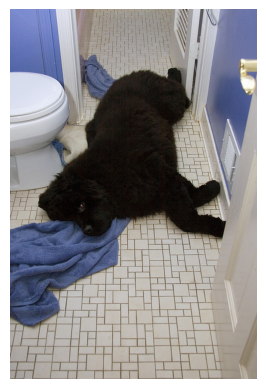

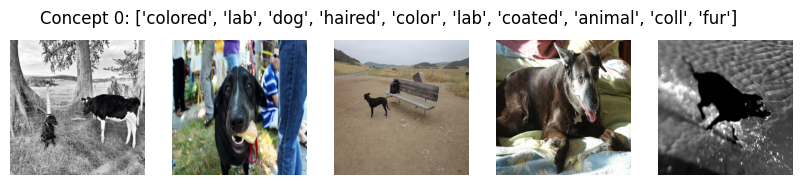

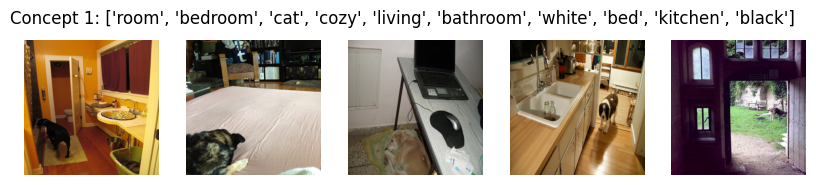

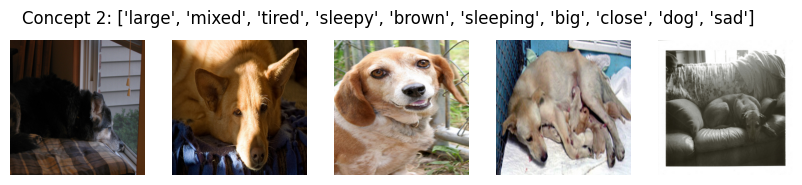

In [55]:
local_explantin(a_test_image, test_data_remapped )